DATA STRUCTURES USED:
✓ TUPLES: Lane settings = (50, 150, 5)
✓ TUPLES: Thresholds = (0.7, 0.4)
✓ SETS: Vehicle classes = {'car', 'truck', 'bus'}
✓ DICT: Priority map = {'person': 1, 'car': 3, 'truck': 4}
✓ LISTS: Created 3 tracking lists

SIMPLE ADAS SYSTEM - ACADEMIC PROJECT

Choose your level:
  
  Level 1: Lane detection only (image)
  Level 2: Object detection only (image)
  Level 3: Complete system (image)
  Level 4: Video processing (full demo)

Uncomment the level you want to run!
    

LEVEL 3: COMPLETE SYSTEM
✓ Command: CAUTION
✓ Reason: car ahead
✓ Saved: level3_output.png


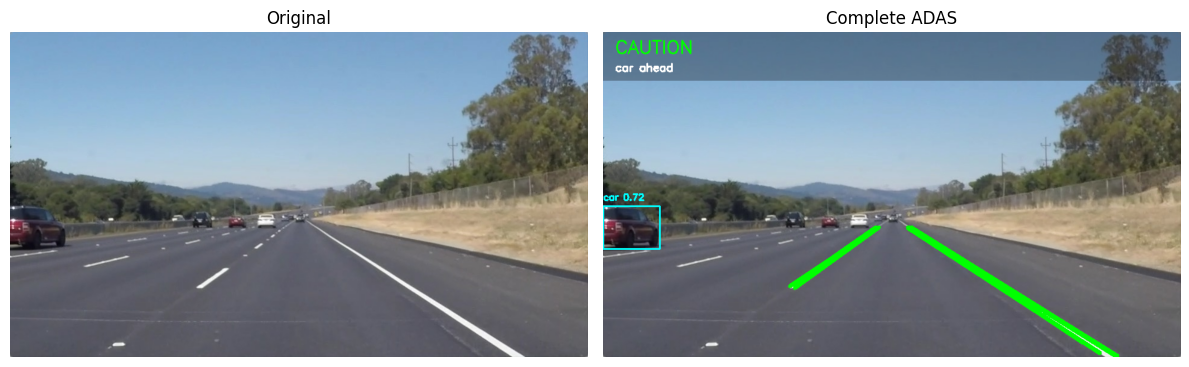

In [11]:
"""
SIMPLE ADAS SYSTEM - Academic Project
Clear demonstration of: Lists, Tuples, Dicts, Sets, NumPy, Pandas, SciPy, Matplotlib
"""

import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal

# ============================================================================
# 1. TUPLES - Configuration (Immutable)
# ============================================================================
print("=" * 60)
print("DATA STRUCTURES USED:")
print("=" * 60)

# Tuple for lane detection settings
LANE_SETTINGS = (50, 150, 5)  # canny_low, canny_high, blur
print("✓ TUPLES: Lane settings =", LANE_SETTINGS)

# Tuple for confidence thresholds
THRESHOLDS = (0.7, 0.4)  # high, low
print("✓ TUPLES: Thresholds =", THRESHOLDS)


# ============================================================================
# 2. SETS - Fast Lookup (O(1))
# ============================================================================

# Sets for object categories
VEHICLES = {'car', 'truck', 'bus'}
PEDESTRIANS = {'person'}
print("✓ SETS: Vehicle classes =", VEHICLES)


# ============================================================================
# 3. DICTIONARIES - Structured Data
# ============================================================================

# Dict for priorities
PRIORITY = {
    'person': 1,    # Highest
    'car': 3,
    'truck': 4
}
print("✓ DICT: Priority map =", PRIORITY)

# Dict for colors
COLORS = {
    'person': (255, 0, 0),      # Red
    'vehicle': (0, 255, 255)    # Cyan
}


# ============================================================================
# 4. LISTS - Dynamic Collections
# ============================================================================

# Lists for storing history
confidence_list = []
detection_list = []
decision_list = []
print("✓ LISTS: Created 3 tracking lists")

print("=" * 60)


# ============================================================================
# SIMPLE LANE DETECTOR
# ============================================================================

def detect_lanes(image):
    """
    Simple lane detection
    Uses: TUPLES (config), NUMPY (arrays), LISTS (storage)
    """
    # Unpack tuple
    canny_low, canny_high, blur = LANE_SETTINGS

    # NUMPY: Image processing
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur_img = cv2.GaussianBlur(gray, (blur, blur), 0)
    edges = cv2.Canny(blur_img, canny_low, canny_high)

    # Simple ROI mask
    height, width = image.shape[:2]
    mask = np.zeros_like(edges)

    # NUMPY: Array for polygon
    polygon = np.array([[
        (width * 0.1, height),
        (width * 0.45, height * 0.6),
        (width * 0.55, height * 0.6),
        (width * 0.9, height)
    ]], dtype=np.int32)

    cv2.fillPoly(mask, polygon, 255)
    masked = cv2.bitwise_and(edges, mask)

    # Detect lines
    lines = cv2.HoughLinesP(masked, 2, np.pi/180, 50, minLineLength=40, maxLineGap=100)

    # Draw lines
    result = image.copy()
    line_count = 0

    if lines is not None:
        line_count = len(lines)
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(result, (x1, y1), (x2, y2), (0, 255, 0), 5)

    # Calculate confidence using NUMPY
    confidence = np.clip(line_count / 10.0, 0, 1)

    # TUPLE return
    return (result, confidence)


# ============================================================================
# SIMPLE OBJECT DETECTOR
# ============================================================================

def detect_objects(image, model):
    """
    Simple object detection
    Uses: SETS (filtering), DICT (data), LISTS (collection)
    """
    results = model(image, conf=0.5, verbose=False)

    # LIST to store detections
    detections = []
    result_img = image.copy()

    for result in results:
        boxes = result.boxes
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            conf = float(box.conf[0])
            cls = model.names[int(box.cls[0])]

            # SET membership test (O(1))
            if cls in VEHICLES or cls in PEDESTRIANS:

                # DICT to store detection info
                det_dict = {
                    'class': cls,
                    'confidence': conf,
                    'box': (x1, y1, x2, y2),  # TUPLE
                    'center': ((x1+x2)//2, (y1+y2)//2),  # TUPLE
                    'priority': PRIORITY.get(cls, 5)
                }

                detections.append(det_dict)

                # Draw box
                color = COLORS['person'] if cls in PEDESTRIANS else COLORS['vehicle']
                cv2.rectangle(result_img, (x1, y1), (x2, y2), color, 2)
                cv2.putText(result_img, f"{cls} {conf:.2f}", (x1, y1-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # TUPLE return
    return (result_img, detections)


# ============================================================================
# SIMPLE DECISION ENGINE
# ============================================================================

def make_decision(detections, confidence):
    """
    Simple decision logic
    Uses: LISTS (filtering), TUPLES (thresholds), DICT (access)
    """
    high_conf, low_conf = THRESHOLDS  # Unpack tuple

    # Check confidence
    if confidence < low_conf:
        return ("SLOW DOWN", "Low lane confidence")

    # LIST COMPREHENSION: Filter pedestrians
    pedestrians = [d for d in detections if d['class'] in PEDESTRIANS]

    if pedestrians:
        return ("STOP", "Pedestrian detected")

    # LIST COMPREHENSION: Filter vehicles
    vehicles = [d for d in detections if d['class'] in VEHICLES]

    if vehicles:
        # Sort by priority (using dict value)
        vehicles.sort(key=lambda x: x['priority'])
        return ("CAUTION", f"{vehicles[0]['class']} ahead")

    return ("CONTINUE", "Path clear")


# ============================================================================
# PANDAS LOGGER
# ============================================================================

def create_log_dataframe(detection_list):
    """
    Create Pandas DataFrame from list of dicts
    Uses: PANDAS (DataFrame, operations)
    """
    # LIST of DICTS to DataFrame
    df = pd.DataFrame(detection_list)

    if df.empty:
        return df

    # PANDAS operations
    print("\n[PANDAS] Detection Statistics:")
    print(f"  Total detections: {len(df)}")
    print(f"  By class:\n{df['class'].value_counts()}")
    print(f"  Average confidence: {df['confidence'].mean():.3f}")

    return df


# ============================================================================
# SCIPY SMOOTHING
# ============================================================================

def smooth_confidence(confidence_list):
    """
    Smooth confidence using SciPy
    Uses: SCIPY (signal processing), NUMPY (arrays)
    """
    if len(confidence_list) < 5:
        return confidence_list

    # LIST to NUMPY array
    conf_array = np.array(confidence_list)

    # SCIPY: Savitzky-Golay filter
    window = min(11, len(conf_array))
    if window % 2 == 0:
        window -= 1

    smoothed = signal.savgol_filter(conf_array, window, 2)

    return smoothed


# ============================================================================
# MATPLOTLIB VISUALIZATION
# ============================================================================

def create_simple_dashboard(confidence_list, detection_list, decision_list):
    """
    Simple 2x2 dashboard
    Uses: MATPLOTLIB (subplots, various plots)
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('ADAS Analysis Dashboard', fontsize=14, fontweight='bold')

    # Plot 1: Confidence over time
    if confidence_list:
        conf_array = np.array(confidence_list)
        frames = np.arange(len(conf_array))

        axes[0, 0].plot(frames, conf_array, 'b-', alpha=0.5, label='Raw')

        # Add smoothed line using SciPy
        if len(conf_array) >= 5:
            smoothed = smooth_confidence(confidence_list)
            axes[0, 0].plot(frames, smoothed, 'r-', linewidth=2, label='Smoothed')

        axes[0, 0].set_title('Lane Confidence Trend')
        axes[0, 0].set_xlabel('Frame')
        axes[0, 0].set_ylabel('Confidence')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Decision distribution
    if decision_list:
        # COUNT decisions using DICT
        decision_counts = {}
        for cmd, _ in decision_list:
            decision_counts[cmd] = decision_counts.get(cmd, 0) + 1

        commands = list(decision_counts.keys())
        counts = list(decision_counts.values())

        axes[0, 1].bar(commands, counts, color='steelblue')
        axes[0, 1].set_title('Decision Distribution')
        axes[0, 1].set_ylabel('Count')
        axes[0, 1].tick_params(axis='x', rotation=45)

    # Plot 3: Confidence histogram
    if confidence_list:
        conf_array = np.array(confidence_list)
        axes[1, 0].hist(conf_array, bins=15, color='green', alpha=0.7, edgecolor='black')

        # NUMPY: Add mean line
        mean = np.mean(conf_array)
        axes[1, 0].axvline(mean, color='red', linestyle='--',
                          label=f'Mean: {mean:.2f}')

        axes[1, 0].set_title('Confidence Distribution')
        axes[1, 0].set_xlabel('Confidence')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].legend()

    # Plot 4: Detection counts by class
    if detection_list:
        # Create PANDAS DataFrame
        df = pd.DataFrame(detection_list)
        class_counts = df['class'].value_counts()

        class_counts.plot(kind='barh', ax=axes[1, 1], color='coral')
        axes[1, 1].set_title('Detections by Class')
        axes[1, 1].set_xlabel('Count')

    plt.tight_layout()
    plt.savefig('dashboard.png', dpi=150, bbox_inches='tight')
    print("\n✓ Dashboard saved: dashboard.png")
    plt.close()


# ============================================================================
# LEVEL 1: LANE ONLY
# ============================================================================

def level_1_lane_only(image_path):
    """Level 1: Just lane detection"""
    print("\n" + "="*60)
    print("LEVEL 1: LANE DETECTION")
    print("="*60)

    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    result, confidence = detect_lanes(image_rgb)

    # Add text
    cv2.putText(result, f"Confidence: {confidence:.2f}", (20, 40),
               cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Display
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(image_rgb)
    axes[0].set_title("Original")
    axes[0].axis('off')

    axes[1].imshow(result)
    axes[1].set_title(f"Lane Detection (Conf: {confidence:.2f})")
    axes[1].axis('off')

    plt.tight_layout()
    plt.savefig('level1_output.png', dpi=150)
    print("✓ Saved: level1_output.png")


# ============================================================================
# LEVEL 2: OBJECTS ONLY
# ============================================================================

def level_2_objects_only(image_path):
    """Level 2: Just object detection"""
    print("\n" + "="*60)
    print("LEVEL 2: OBJECT DETECTION")
    print("="*60)

    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    model = YOLO('yolov8n.pt')
    result, detections = detect_objects(image_rgb, model)

    # Display
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(image_rgb)
    axes[0].set_title("Original")
    axes[0].axis('off')

    axes[1].imshow(result)
    axes[1].set_title(f"Objects Detected: {len(detections)}")
    axes[1].axis('off')

    plt.tight_layout()
    plt.savefig('level2_output.png', dpi=150)
    print(f"✓ Detected {len(detections)} objects")
    print("✓ Saved: level2_output.png")


# ============================================================================
# LEVEL 3: COMPLETE ON IMAGE
# ============================================================================

def level_3_complete_image(image_path):
    """Level 3: Complete system on single image"""
    print("\n" + "="*60)
    print("LEVEL 3: COMPLETE SYSTEM")
    print("="*60)

    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    model = YOLO('yolov8n.pt')

    # Step 1: Lanes
    lane_img, confidence = detect_lanes(image_rgb)

    # Step 2: Objects
    detected_img, detections = detect_objects(lane_img, model)

    # Step 3: Decision
    command, reason = make_decision(detections, confidence)

    # Add overlay
    final = detected_img.copy()
    cv2.rectangle(final, (0, 0), (final.shape[1], 80), (0, 0, 0), -1)
    final = cv2.addWeighted(detected_img, 0.7, final, 0.3, 0)

    color = (255, 0, 0) if "STOP" in command else (0, 255, 0)
    cv2.putText(final, command, (20, 35),
               cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    cv2.putText(final, reason, (20, 65),
               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    # Display
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(image_rgb)
    axes[0].set_title("Original")
    axes[0].axis('off')

    axes[1].imshow(final)
    axes[1].set_title("Complete ADAS")
    axes[1].axis('off')

    plt.tight_layout()
    plt.savefig('level3_output.png', dpi=150)
    print(f"✓ Command: {command}")
    print(f"✓ Reason: {reason}")
    print("✓ Saved: level3_output.png")


# ============================================================================
# LEVEL 4: VIDEO PROCESSING
# ============================================================================

def level_4_video(video_path, output_path='output.mp4'):
    """Level 4: Process entire video"""
    print("\n" + "="*60)
    print("LEVEL 4: VIDEO PROCESSING")
    print("="*60)

    # Open video
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Video: {width}x{height}, {fps} FPS, {total} frames")

    # Output
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Load model
    model = YOLO('yolov8n.pt')

    frame_num = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_num += 1
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Process
        lane_img, confidence = detect_lanes(frame_rgb)
        detected_img, detections = detect_objects(lane_img, model)
        command, reason = make_decision(detections, confidence)

        # Store in LISTS
        confidence_list.append(confidence)
        detection_list.extend(detections)
        decision_list.append((command, reason))

        # Add overlay
        final = detected_img.copy()
        cv2.rectangle(final, (0, 0), (width, 90), (0, 0, 0), -1)
        final = cv2.addWeighted(detected_img, 0.7, final, 0.3, 0)

        color = (255, 0, 0) if "STOP" in command else (0, 255, 0)
        cv2.putText(final, command, (20, 35),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, color, 3)
        cv2.putText(final, reason, (20, 65),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
        cv2.putText(final, f"Frame {frame_num}/{total}", (width-200, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        # Write
        final_bgr = cv2.cvtColor(final, cv2.COLOR_RGB2BGR)
        out.write(final_bgr)

        if frame_num % 30 == 0:
            print(f"  Progress: {frame_num}/{total} frames")

    cap.release()
    out.release()

    print(f"\n✓ Video saved: {output_path}")
    print(f"✓ Processed {frame_num} frames")

    # Create Pandas log
    df = create_log_dataframe(detection_list)
    if not df.empty:
        df.to_csv('detection_log.csv', index=False)
        print("✓ CSV saved: detection_log.csv")

    # Create dashboard
    create_simple_dashboard(confidence_list, detection_list, decision_list)

    # Print summary
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)

    # NUMPY stats
    if confidence_list:
        conf_array = np.array(confidence_list)
        print(f"\n[NumPy] Confidence:")
        print(f"  Mean: {np.mean(conf_array):.3f}")
        print(f"  Std: {np.std(conf_array):.3f}")

    # LIST stats
    print(f"\n[Lists] Data collected:")
    print(f"  Confidence points: {len(confidence_list)}")
    print(f"  Total detections: {len(detection_list)}")
    print(f"  Decisions made: {len(decision_list)}")

    # DICT stats
    decision_counts = {}
    for cmd, _ in decision_list:
        decision_counts[cmd] = decision_counts.get(cmd, 0) + 1

    print(f"\n[Dict] Decision counts:")
    for cmd, count in decision_counts.items():
        print(f"  {cmd}: {count}")


# ============================================================================
# MAIN - CHOOSE YOUR LEVEL
# ============================================================================

if __name__ == "__main__":
    print("\n" + "="*60)
    print("SIMPLE ADAS SYSTEM - ACADEMIC PROJECT")
    print("="*60)
    print("""
Choose your level:

  Level 1: Lane detection only (image)
  Level 2: Object detection only (image)
  Level 3: Complete system (image)
  Level 4: Video processing (full demo)

Uncomment the level you want to run!
    """)

    # UNCOMMENT ONE TO RUN:

    #level_1_lane_only('solidWhiteCurve.jpg')
    # level_2_objects_only('road_image.jpg')
    level_3_complete_image('solidWhiteRight.jpg')
    # level_4_video('dashcam.mp4', 'output.mp4')

    print("="*60)

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.6 MB/s eta 0:00:00


enter option1


After installing the library, you can run the code cell again.